# Introduction
Submit a report (pdf or a clean notebook) for the following machine learning project. Explain briefly in the report the architectures that you used, how they were trained, tuned, etc. Describe challenges and problems and how they were addressed. Present in the report your experimental results and demos (e.g., screenshots) showing how your code works. Do not include code in the report, but include a link to a shared folder or repository (e.g. in Dropbox, GitHub, Bitbucket) containing your code. The project will contribute 60% to the final grade.

# X-Ray classification
Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. You must use at least 2 different architectures, one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and one with a popular pre-trained CNN model (e.g., VGG-19, ResNet, etc.). Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found at https://stanfordmlgroup.github.io/competitions/mura/. To download the dataset you must fill out a form, so complete this action as soon as possible.

## What is MURA?
MURA (musculoskeletal radiographs) is a large dataset of bone X-rays. Algorithms are tasked with determining whether an X-ray study is normal or abnormal.

Musculoskeletal conditions affect more than 1.7 billion people worldwide, and are the most common cause of severe, long-term pain and disability, with 30 million emergency department visits annually and increasing. We hope that our dataset can lead to significant advances in medical imaging technologies which can diagnose at the level of experts, towards improving healthcare access in parts of the world where access to skilled radiologists is limited.

MURA is one of the largest public radiographic image datasets. We're making this dataset available to the community and hosting a competition to see if your models can perform as well as radiologists on the task.

## About
We introduce MURA, a large dataset of musculoskeletal radiographs containing 40,561 images from 14,863 studies, where each study is manually labeled by radiologists as either normal or abnormal. To evaluate models robustly and to get an estimate of radiologist performance, we collect additional labels from six board-certified Stanford radiologists on the test set, consisting of 207 musculoskeletal studies. On this test set, the majority vote of a group of three radiologists serves as gold standard. We train a 169-layer DenseNet baseline model to detect and localize abnormalities. Our model achieves an AUROC of 0.929, with an operating point of 0.815 sensitivity and 0.887 specificity. We compare our model and radiologists on the Cohen's kappa statistic, which expresses the agreement of our model and of each radiologist with the gold standard. Model performance is comparable to the best radiologist performance in detecting abnormalities on finger and wrist studies. However, model performance is lower than best radiologist performance in detecting abnormalities on elbow, forearm, hand, humerus, and shoulder studies. We believe that the task is a good challenge for future research.

# Introduction

Our approach will be highly influenced by what was implemented on the [paper](https://arxiv.org/abs/1712.06957). Below are some points to take into consideration:

* The model used was a 169 layer DenseNet
* The test set (which the paper used to evaluate the scores) is not available publicly. We will have to split the data provided into train, valid & test, which means that the train data will be smaller than the one in the paper.
* Multiple Images for the same patient/body part are ensembled in the paper to get the final prediction.
* In order to perform the split, the paper suggest that there is no overlap between patients. A patient which is present in the train set, should not be part of the validation set, even for a different bodypart. "*The clinical images vary in resolution and in aspect ratios. We split the dataset into training (11,184 patients, 13,457 studies, 36,808 images), validation (783 patients, 1,199 studies, 3,197 images), and test (206 patients, 207 studies, 556 images) sets. There is no overlap in patients between any of the sets.*"
* The threshold for abnormal prediction is 0.5.

## Pre-processing
* Images were normalized to match ImageNet training set (same mean and std). 
* scaling to 320x320 was applied
* Data augmentation was used, using data horizontal flips, along with 30 degree rotations.
* Weights were initializaed with the weights from a model pre-trained on ImageNet
* the network was trained with Adam with:
    * $\beta_1 = 0.9$ and $\beta_2 = 0.999$
    * batch size 8
    * learning rate 0.0001
    * ReduceLROnPlateau with a patience of 1
    * 5 models were ensebled

# Our approach

We had to approach the problem by keeping in mind time and resource limitations. For this reason we came with the following approach:

Use 3 models:
* CNN model
* pre-trained densenet model
* stacked pre-trained model (densenet and mobilenet)

Use data augmentation for train data:
* normalize (0-1), random rotation (0-30), horizontal flip, brightness and contrast adjustment

Keep parameters frozen in all pre-trained models to be able to complete training. Un-freezing the parameters requires a very small learning rate and resulted in runtime errors before one epoch could be completed.

Run training for as long as the resources allow. We performed multiple runs, loading models were possible. For this reason the notebooks containing the executed models might not represent the actual runs.

Use a combination of resources (kaggle and colab) which require different handling in loading files. To re-produce the code, it is advised to run each one to the corresponding platform.

Save models in WANDB to be able to load them and combine the results in the presented notebook

## Improvements

Use data augmentation only for abnormal label (to balance dataset)
Fine-Tune with trainable layers
Train body-part specific models and ensemble with the one that was trained on all body parts


# Imports

In [294]:
import gc
import re
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
pd.set_option('display.max_columns', None)
import cv2

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from typing import List, Dict, Optional, Tuple, Any, Union

import wandb
from wandb.keras import WandbCallback

In [4]:
# NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Num GPUs Available:  1
Number of accelerators:  1


# Globals

In [5]:
# define path under which MURA-v1.1/ is located:
root_path: str = "/kaggle/input/mura-x-ray-dataset/"
os.chdir(root_path)
os.getcwd()

'/kaggle/input/mura-x-ray-dataset'

# [Weights & Biases](https://wandb.ai/aueb/Deep_Learning_2)

In order to make experiment tracking easier we will use [Weights & Biases](wandb.ai/home), which offers a free lisence for academic purposes. For the sake of this assignment a team has been created:https://wandb.ai/aueb. Access can be granted by contacting the authors.

* Note that this code assumes that you have already set up a Wandb account and API key. If you haven't done so yet, you will need to sign up for a free account at https://wandb.ai/ and follow the instructions there to obtain your API key.



In [6]:
wandb.login()

wandb: WARNING Path /kaggle/input/mura-x-ray-dataset/wandb/ wasn't writable, using system temp directory.
wandb: WARNING Path /kaggle/input/mura-x-ray-dataset/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/mura-x-ray-dataset/wandb/ wasn't writable, using system temp directory
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load Data

Data has the following structure:

```
├──MURA
  ├──train_image_paths.csv
  ├──train_labeled_studies.csv
  ├──valid_image_paths.csv
  ├──valid_labeled_studies.csv
  ├──train
  │   └─ BODY PART
  │       └─ patientxxx
  │          .
  │          .
  │          .
  │    .
  │    .
  │    .
  └──test
      └─ BODY PART
          └─ patientxxx
             .
             .
             .
       .
       .
       .  
```

We will create a dataframe that uses these paths as rows and extract any information needed.

In [7]:
def extract_set_category(string: str) -> dict:
    """
    Extracts the 'set_type' and 'category' from a given string using regular expressions.

    Parameters:
        string (str): A string containing the 'set' and 'category' information.

    Returns:
        dict: A dictionary containing the 'set' and 'category' information.
    """

    pattern = r".*(?P<set_type>train|valid)/(?P<category>XR_[A-Z]+)/(?P<patient_id>patient\d+)/study.*"
    match = re.match(pattern, string)
    if match:
        return {'set_type': match.group('set_type'), 'category': match.group('category'), 'patient_id': match.group('patient_id')}
    else:
        return None
    
def generate_path_df(dataset_type: str, dataset_path: str = "/kaggle/input/mura-x-ray-dataset/") -> pd.DataFrame:
    """
    Reads in the image paths and labels for a given dataset type (train or valid) from the MURA dataset.
    Returns a pandas DataFrame containing the image paths, labels, and the dataset type.
    
    Parameters:
        dataset_type (str): The type of dataset to read in (train or valid)
        dataset_path (str): The path to the MURA dataset folder (default: '/kaggle/input/mura-x-ray-dataset/')
    
    Returns:
        pd.DataFrame: A pandas DataFrame containing the image paths, labels, and dataset type.
    """
        
    # Read in the image paths csv file and assign the column name 'image_path'
    train_label_paths = pd.read_csv(f"{dataset_path}/MURA-v1.1/{dataset_type}_image_paths.csv", header=None, names=['image_path'])
    
    # Extract the path to the folder containing the image file and create a new column 'path'
    train_label_paths["path"] = train_label_paths.apply(lambda x: "/".join(x['image_path'].split("/")[:-1]) + "/", axis=1)
    
    # Read in the labeled studies csv file and assign column names 'path' and 'label'
    train_labels = pd.read_csv(f"{dataset_path}/MURA-v1.1/{dataset_type}_labeled_studies.csv", header=None, names=['path', 'label'])
    
    # Merge the two DataFrames on the 'path' column and create a new column 'image_type'
    _df = train_labels.merge(train_label_paths, on='path', how='left')
    
    # Check that the length of the two DataFrames match
    assert len(train_label_paths) == len(_df)
    
    return _df

def generate_dataframes(dataset_path: str = "/kaggle/input/mura-x-ray-dataset/") -> pd.DataFrame:
    """Perfoms actions needed to load the dataset with image paths and additional info"""
    
    # read train test_dataframe
    train: pd.DataFrame = generate_path_df(dataset_type="train")
    test: pd.DataFrame = generate_path_df(dataset_type="valid")

    # join dataframes
    _df = pd.concat([train, test]).reset_index()

    # Apply the extract_set_category function to each row of the DataFrame.
    _df = pd.concat([_df, pd.DataFrame(_df['path'].apply(lambda x: extract_set_category(x)).tolist())], axis=1)
    mapping: dict = {1: "abnormal", 0: "normal"}
    _df['label_type'] = _df['label'].apply(lambda x: mapping[x])
    
    
    # re-order columns
    cols = list(_df.columns)
    cols.remove("label")
    cols.append("label")
    _df = _df[cols]
    
    _df.drop(["index"], axis=1, inplace=True)
    
    return _df

In [245]:
data = generate_dataframes()
data.head()

,path,image_path,set_type,category,patient_id,label_type,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train,XR_SHOULDER,patient00001,abnormal,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train,XR_SHOULDER,patient00001,abnormal,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train,XR_SHOULDER,patient00001,abnormal,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train,XR_SHOULDER,patient00002,abnormal,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train,XR_SHOULDER,patient00002,abnormal,1


# Visualize

In [243]:
def plot_label_counts(data, normalize: bool = True) -> None:
    """
    Plots the label count per set type and category in the MURA dataset.

    Parameters:
        data (pd.DataFrame): The MURA dataset.

    Returns:
        None
    """  
    # Calculate the label count per set type, category, and label type
    data_count = data.groupby(['category','set_type', 'label_type'])['label_type'].count().unstack(level=-1)
    
    if normalize:
        # Normalize the data to get the label count percentage per set type and category
        data_count = data_count.div(data_count.sum(axis=1), axis=0)
    
    # keep categories in list
    cat = data['category'].unique()

    # Create a figure with subplots for each category
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

    # Loop through each category and create a bar plot
    for i, ax in enumerate(axs.flat):
        try:
            # pivot data for plotting
            pivot = data_count.loc[cat[i]]

            # plot side by side bar chart
            pivot.plot(kind='bar', rot=0, ax=ax)
            ax.set_title(cat[i])
            ax.set_xlabel("")
            ax.set_ylabel('Label Count')
            ax.legend().set_visible(False)
        except IndexError:
            break


    # Add a legend & title
    fig.legend(['Abnormal', 'Normal'], loc='upper left')
    fig.suptitle('Label Count per Set Type and Category', fontsize=16)

    plt.tight_layout()
    _ = plt.show()

In [10]:
def plot_images(path: str, ax: plt.axis) -> None:
    """
    Reads an image from the given path, resizes it to (320, 320), and plots it on the given axis 
    with no axis ticks.
    """
    # read image
    img = cv2.imread(path)
    # resize image
    img = cv2.resize(img, (320, 320))

    # plot image
    ax.imshow(img)
    ax.axis('off')
    
def plos_x_rays(data: pd.DataFrame) -> None:
    """
    Plots 8 x-ray images from the given data with their corresponding body parts and label types 
    in a 2x4 grid of subplots.

    """
    # find image paths for plot
    images_path: list = []
    for category in np.append(data.category.unique(),data.category.unique()[0]): # to get 8 labels

        # find info
        path: str = data.loc[data.category == category].image_path.values[0]
        body_part: str = data.loc[data.category == category].category.values[0]
        label_type: str = data.loc[data.category == category].label_type.values[0]

        # append info to list
        images_path.append({"path": path, 
                           "body_part": body_part,
                           "label_type": label_type}) 

    # example usage for 8 images in a 2x4 grid of subplots
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))
    for i, ax in enumerate(axs.flat):

        img_path = images_path[i]['path']
        plot_images(img_path, ax)
        ax.set_title(f"{images_path[i]['body_part']}: {images_path[i]['label_type']}")


    plt.tight_layout()
    plt.show()

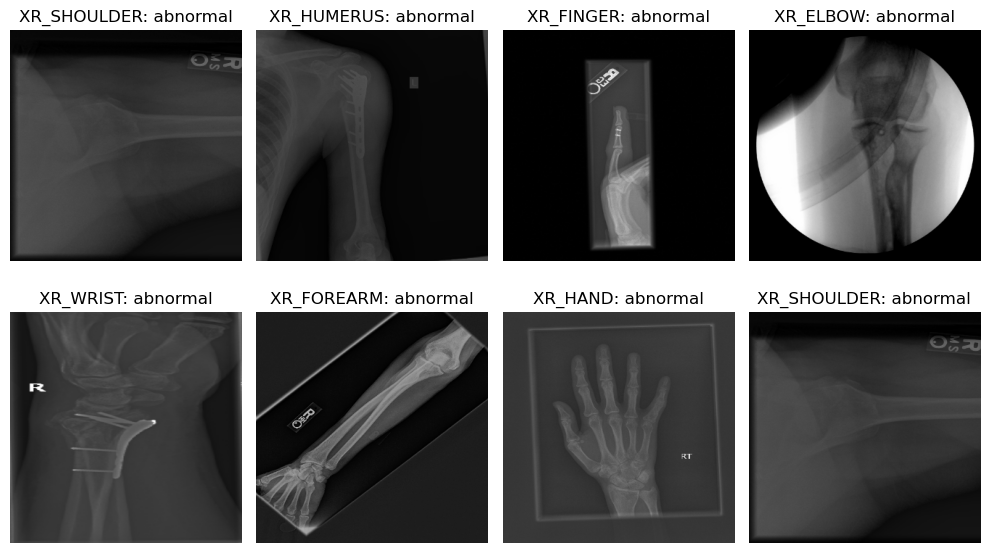

In [11]:
plos_x_rays(data)

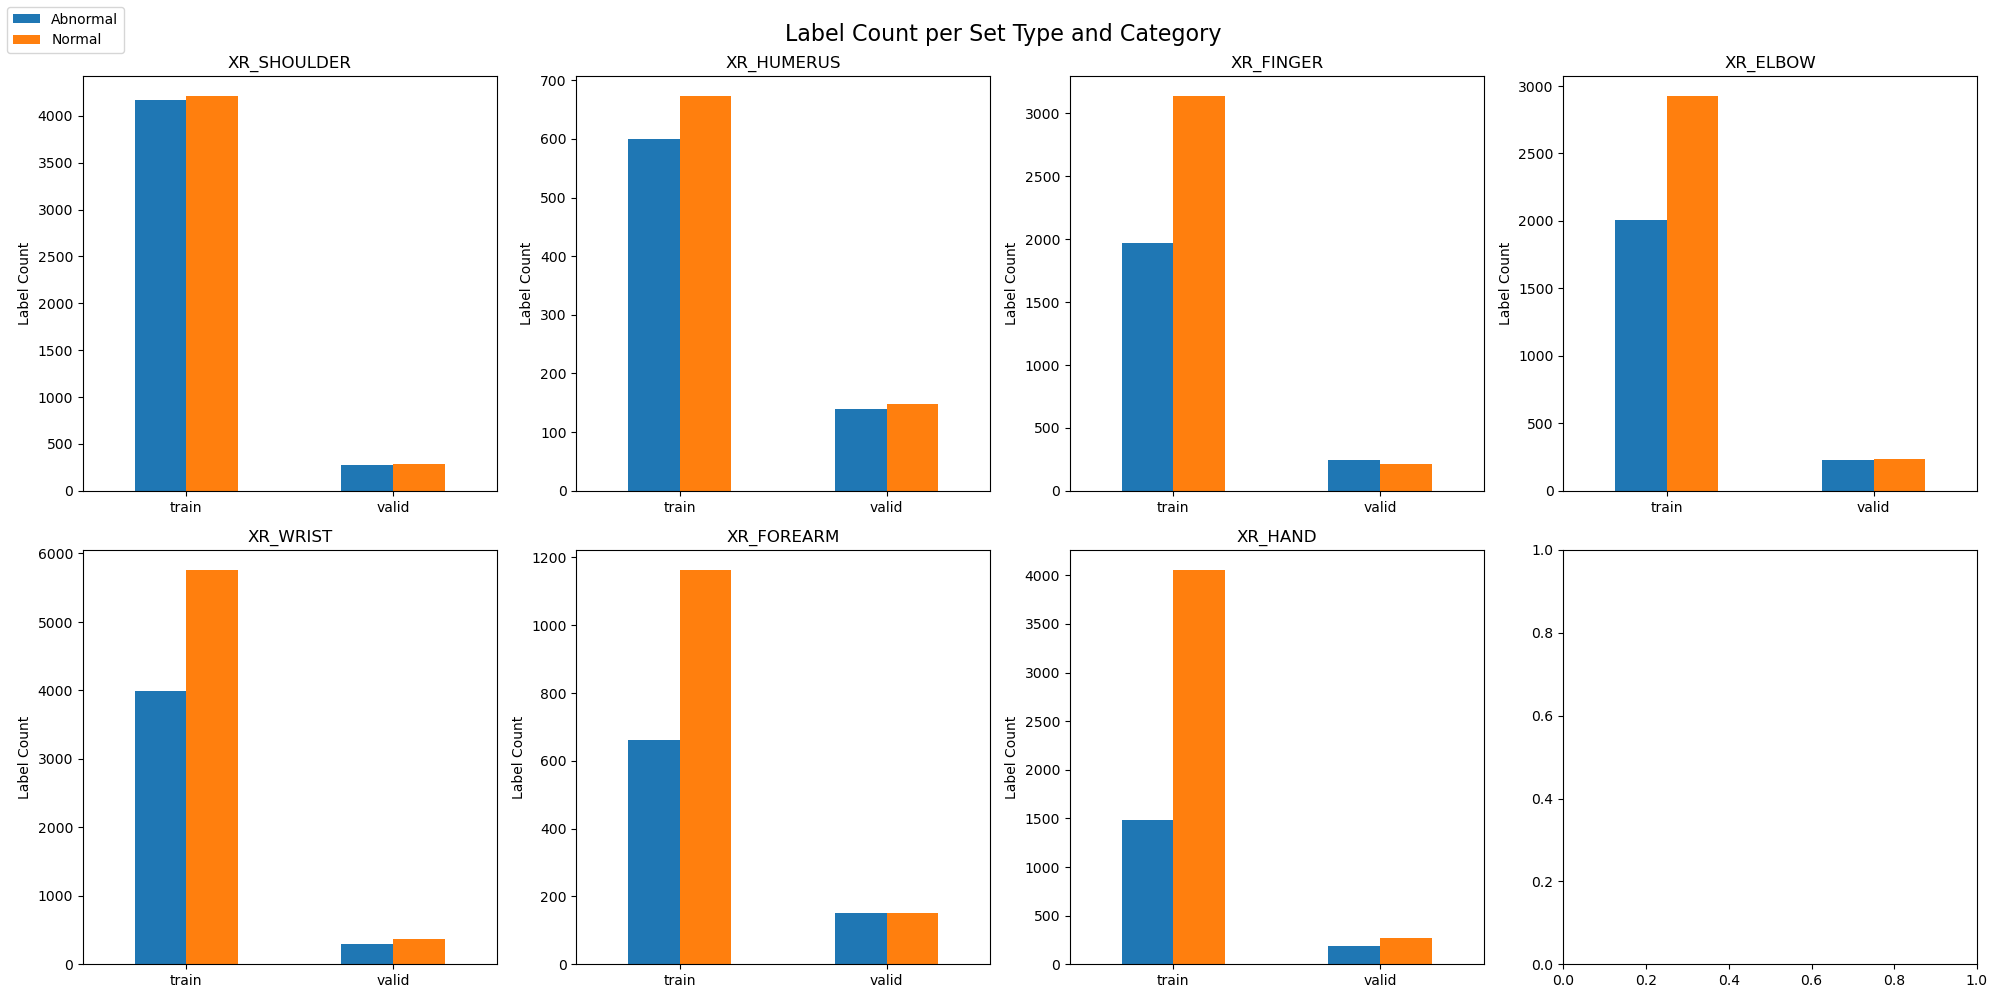

In [246]:
plot_label_counts(data, normalize=False)

# Train Dev Test (valid) split

* in order not to have any dependencies on the order of the data, we will shuffle the data. Moreover, 10% of the input data will be used as validation and 10% as test.

As described in the Paper we will make sure not to have overlap between patients in the various sets. We shuffle the patients, and then split the dataset  

In [247]:
# take unique patient_ids and shuffle
patients = data.patient_id.unique()
np.random.seed(41)
np.random.shuffle(patients)

# split three list of patient_ids
length_80 = patients[:int(len(patients)*0.85)]
length_80_90 = patients[int(len(patients)*0.85):int(len(patients)*0.9)]
length_90_100 = patients[int(len(patients)*0.9):]

# sanity check
data.loc[data.patient_id.isin(length_80)].describe()\
.join(data.loc[data.patient_id.isin(length_80_90)].describe(),rsuffix="_Validation")\
.join(data.loc[data.patient_id.isin(length_90_100)].describe(), rsuffix="_Test")

,label,label_Validation,label_Test
count,34067.000000,1957.000000,3981.000000
mean,0.412041,0.375575,0.409696
std,0.492210,0.484395,0.491839
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


* Update the labels for each set & save dataframes to variables

In [248]:
# update labels
data.loc[data.patient_id.isin(length_80), "set_type"] = "train"
data.loc[data.patient_id.isin(length_80_90), "set_type"] = "validation"
data.loc[data.patient_id.isin(length_90_100), "set_type"] = "test"

# Convert to sstring
data["label"] = data["label"].astype(str)

train: pd.DataFrame = data.loc[data.set_type == 'train']
valid: pd.DataFrame = data.loc[data.set_type == 'validation']
test: pd.DataFrame = data.loc[data.set_type == 'test']
test.reset_index(inplace=True)

* visualize new class distribution. It seems that the selected seed provides a balanced set to train.

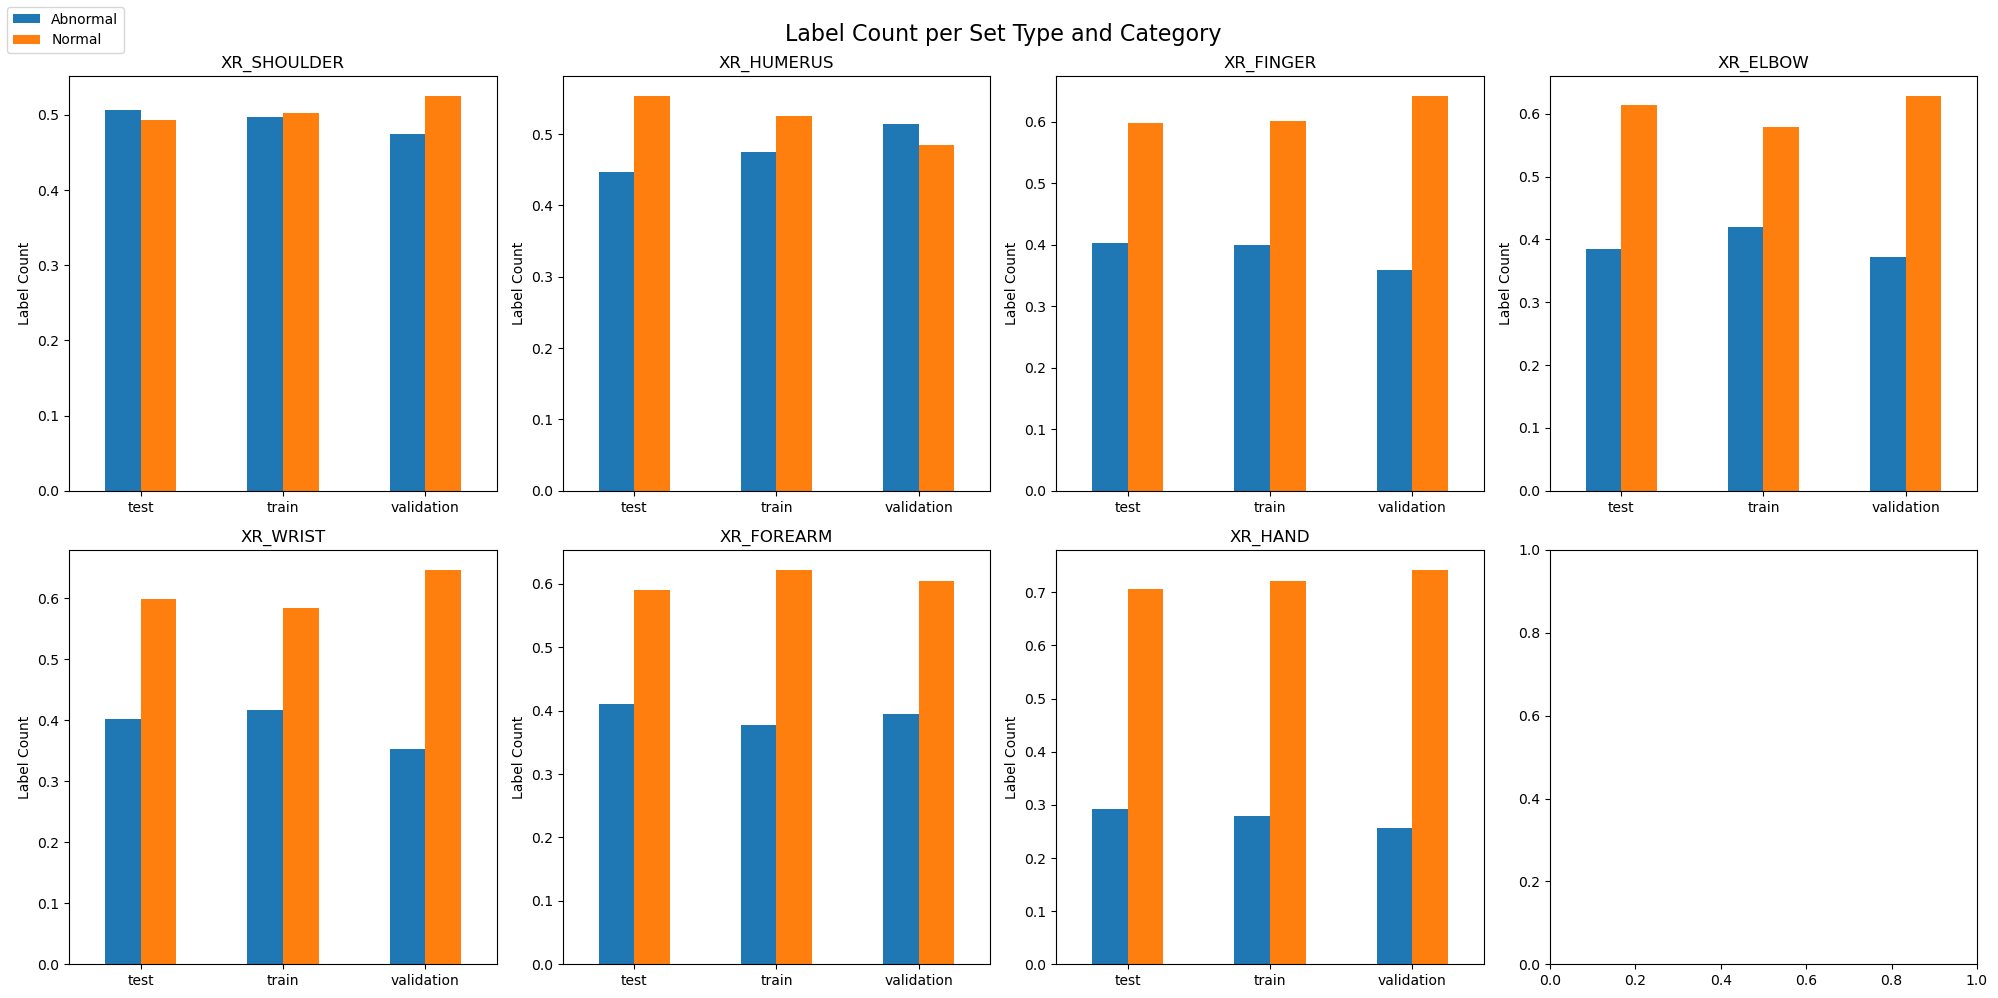

In [250]:
plot_label_counts(data)

# Generate Test iterator for predictions

For this part of the assignment only the validation of test sets will be used to make predictions, thus the data iterator for the train data will be skipped.

In [16]:
from PIL import ImageEnhance, Image
# Define the preprocessing function
def normalize(x):
    x /= 255.0  # Scale pixel values to [0, 1]
    
    # normalize to imagenet mean and std
    x -= [0.485, 0.456, 0.406]    
    x /= [0.229, 0.224, 0.225]     
    
    return x

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.8, 1.2))
    image = np.array(image)/255.0  # normalize
    return image

In [150]:
x_col='image_path'
y_col='label'
batch_size=64
seed=42
shuffle=True
class_mode='binary'
target_size=(320,320)

valid_test_datagen = ImageDataGenerator(
     rescale=1.0/255.0
)

valid_iterator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col=x_col,
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=target_size
)

test_iterator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col=x_col,
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=target_size
)

Found 1957 validated image filenames belonging to 2 classes.
Found 3981 validated image filenames belonging to 2 classes.


# Load best models from WANDB

Link: https://wandb.ai/aueb/Deep_Learning_2

All 3 models are saved in the WANDB corresponding repository. We will use the best models for CNN, densenet and stacked (densenet + MobileNetV2) that we received from each run.

In [18]:
def load_model(model: str, project: str = "Deep_Learning_2"):
    # load the best model
    wandb.init(mode="disabled")
    api = wandb.Api()
    artifact = api.artifact(f'aueb/{project}/{model}', type='model')
    artifact.download()

    metrics = [tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
               'accuracy']

    artifact_model = tf.keras.models.load_model(f"./artifacts/{model}", custom_objects={"cohen_kappa": metrics[0]})

    return artifact_model

def load_best_models(cnn: str = 'model-CNN_baseline_test_small:v3',
                    pre_trained: str = 'model-CNN_densenet_frozen:v9',
                    stacked: str = 'model-Stacked_frozen:v18') -> Tuple[tf.keras.Model, tf.keras.Model, tf.keras.Model]:
    _cnn =  load_model(cnn)
    _pre_trained = load_model(pre_trained)
    _stacked = load_model(stacked)
    
    return _cnn, _pre_trained, _stacked

def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [19]:
os.chdir("/home")
cnn, pre_trained, stacked = load_best_models()
os.chdir(root_path)
cnn._name = 'cnn'
pre_trained._name = 'densenet_pretrained'
stacked._name = 'stacked'

wandb:   5 of 5 files downloaded.  
wandb: Downloading large artifact model-CNN_densenet_frozen:v9, 60.99MB. 5 files... 
wandb:   5 of 5 files downloaded.  
Done. 0:0:4.7
wandb: Downloading large artifact model-Stacked_frozen:v18, 82.66MB. 5 files... 
wandb:   5 of 5 files downloaded.  
Done. 0:0:5.4


# Print model summaries

Print the architectures used for each model. Note that the stacked model uses 224x224 input shapes due to Imagenet restrictions.

## CNN

In [20]:
cnn.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 320, 320, 3)]     0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 320, 320, 64)      1792      
                                                                 
 BatchNormalization-1 (Batch  (None, 320, 320, 64)     256       
 Normalization)                                                  
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 160, 160, 64)      0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 160, 160, 64)      102464    
                                                                 
 BatchNormalization-2 (Batch  (None, 160, 160, 64)     256       
 Normalization)                                                

## Densenet pre-trained

In [21]:
pre_trained.summary()

Model: "densenet_pretrained"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 320, 320, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 10, 10, 1664)      12642880  
                                                                 
 Pooling2D-Densenet (GlobalA  (None, 1664)             0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


## Stacked model summary

In [22]:
stacked.summary()

Model: "stacked"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['Input[0][0]']                  
 al)                                                                                              
                                                                                                  
 densenet169 (Functional)       (None, 7, 7, 1664)   12642880    ['Input[0][0]']                  
                                                                                            

# Predicitons on Test Set (No optimization, results per image)

We will make predictions on the test set for each model.

In [28]:
for _model in [cnn, pre_trained, stacked]:    
    # evaluate
    test_iterator.reset
    print(f"--- {_model.name:^20} ---")
    _eval = _model.evaluate(test_iterator)
    print(f"{'Test Loss:':<20} {_eval[0]:.5f}")
    print(f"{'Test CohenKappa:':<20} {_eval[1]:.5f}")
    print(f"{'Test Accuracy:':<20} {_eval[2]:.5f}")
    
    print("\n\n")
    wandb.finish()

---         cnn          ---
63/63 [==============================] - 38s 600ms/step - loss: 0.7003 - cohen_kappa: 0.1362 - accuracy: 0.5333
Test Loss:           0.70025
Test CohenKappa:     0.13620
Test Accuracy:       0.53328



--- densenet_pretrained  ---
63/63 [==============================] - 32s 507ms/step - loss: 0.5635 - cohen_kappa: 0.3883 - accuracy: 0.7167
Test Loss:           0.56352
Test CohenKappa:     0.38827
Test Accuracy:       0.71665



---       stacked        ---
63/63 [==============================] - 33s 526ms/step - loss: 0.5248 - cohen_kappa: 0.4511 - accuracy: 0.7496
Test Loss:           0.52479
Test CohenKappa:     0.45108
Test Accuracy:       0.74956





In [200]:
# Save prediciton in variable
test_iterator.reset
cnn_pred = cnn.predict(test_iterator)

test_iterator.reset
densenet_pred = pre_trained.predict(test_iterator)

test_iterator.reset
stacked_pred = stacked.predict(test_iterator)

true_labels = test.label.astype(int)

63/63 [==============================] - 34s 536ms/step


## Classification Report


In [74]:
print(f'CNN:\n{classification_report(true_labels, tf.round(cnn_pred))}\n')
print("-"*54)

print(f'Densenet:\n{classification_report(true_labels, tf.round(densenet_pred))}\n')
print("-"*54)

print(f'Stacked:\n{classification_report(true_labels, tf.round(stacked_pred))}')

CNN:
              precision    recall  f1-score   support

           0       0.72      0.34      0.46      2350
           1       0.46      0.81      0.59      1631

    accuracy                           0.53      3981
   macro avg       0.59      0.58      0.52      3981
weighted avg       0.62      0.53      0.51      3981


------------------------------------------------------
Densenet:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78      2350
           1       0.71      0.52      0.60      1631

    accuracy                           0.72      3981
   macro avg       0.72      0.69      0.69      3981
weighted avg       0.72      0.72      0.71      3981


------------------------------------------------------
Stacked:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2350
           1       0.81      0.51      0.62      1631

    accuracy                           0.75   

## Plot results

In [295]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, accuracy_score
import seaborn as sns


def plot_cm(true_labels: [np.array], predicted_labels: List[np.array], models: List[str], title: str = '', size: tuple = (17,5)):
    """
    Plots the confusion matrix
    """
    
    fig = plt.figure(figsize=size)
    fig.suptitle(f'{title} Confusion Matrices', fontsize=18)

    for i, preds in enumerate(predicted_labels):
        cm = confusion_matrix(true_labels, preds)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        
        ax = fig.add_subplot(1, 3, i+1)
        sns.heatmap(cm, annot=True, fmt=fmt, ax=ax, cmap=plt.cm.YlGnBu,  annot_kws={"size":14}, 
                    yticklabels=['Normal', 'Abnormal'], 
                    xticklabels=['Normal', 'Abnormal'])
        
        
        if i == 0:    
            ax.set_ylabel('True labels', fontsize=15)
        ax.set_title(f'{models[i]}\'s Predictions', size=14)
    fig.supxlabel(f'Predicted labels', fontsize=15)
    fig.tight_layout()
    return plt.show()

### Confusion Matrices

We can see some interesting results for the three models. 

* the CNN model seem to have a very good prediction rate for the abnormal cases, but the result for the normal cases is terrible. The model had a huge validation loss and looked like overfitted in the training data.
* on the other hand, the two pre-trained models had a better behaviour on the Normal case, but the results for the Abnormal case were not that good. Looking at the training plots, we can see that the model did not overfit, but rather needed more epochs of training, since the validation loss was decreasing and the val_accuracy increasing. Unfortunately we did not have the time to perform more epochs.

Finally it is worth mentioning that the pre-trained layers were frozen. If we had the resources, we would have unfreezed the pre-trained layers with a very small learning rate, to further fine-tune the model and see the results.

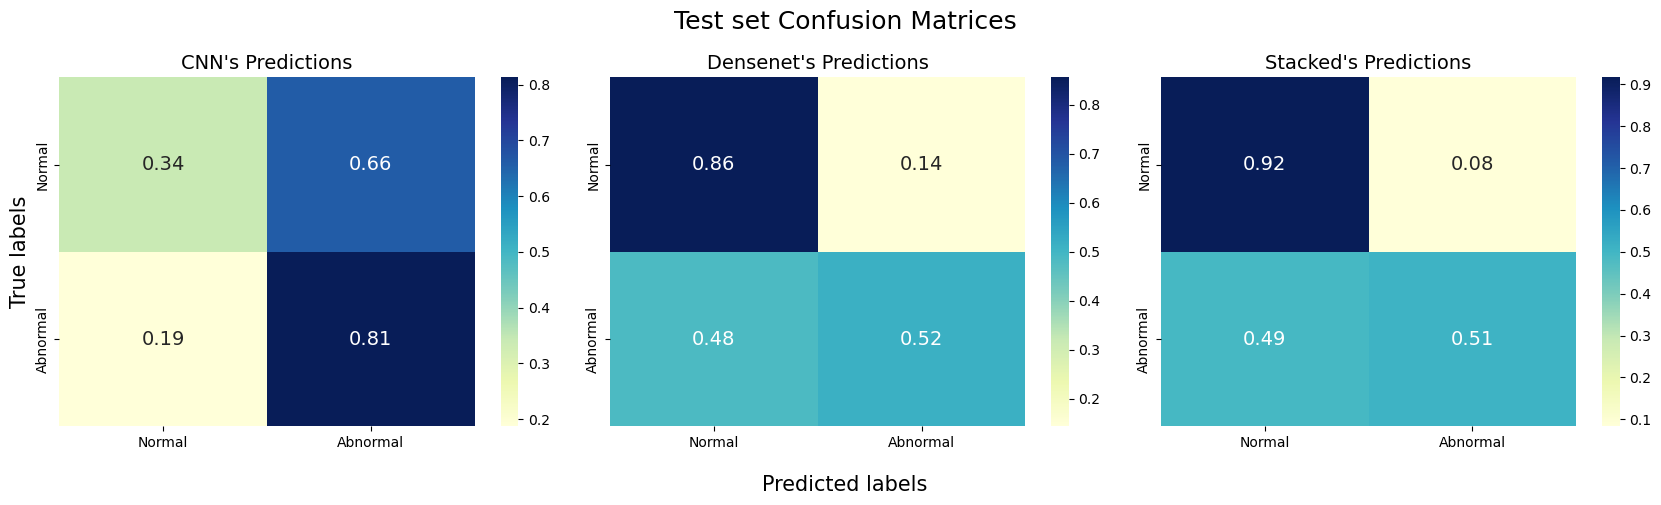

In [238]:
plot_cm(true_labels=true_labels, predicted_labels=[tf.round(cnn_pred), tf.round(densenet_pred), tf.round(stacked_pred)], models=["CNN", "Densenet", "Stacked"], title='Test set')

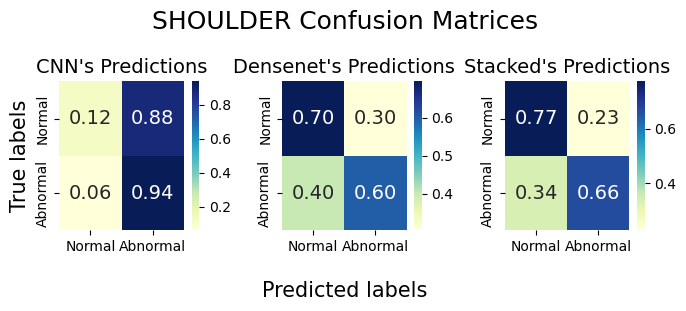

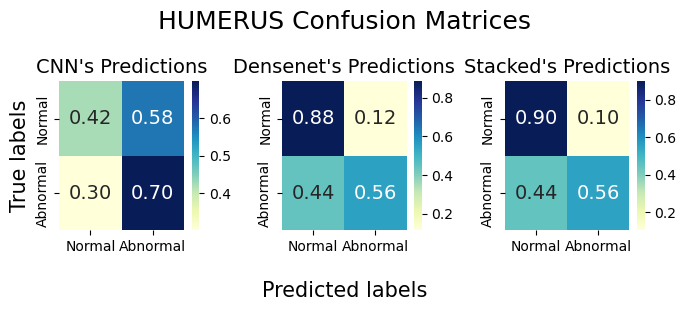

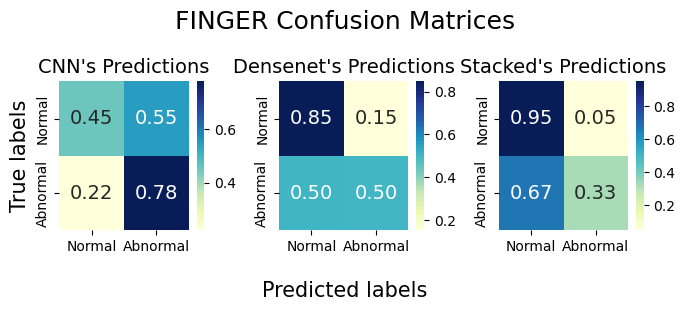

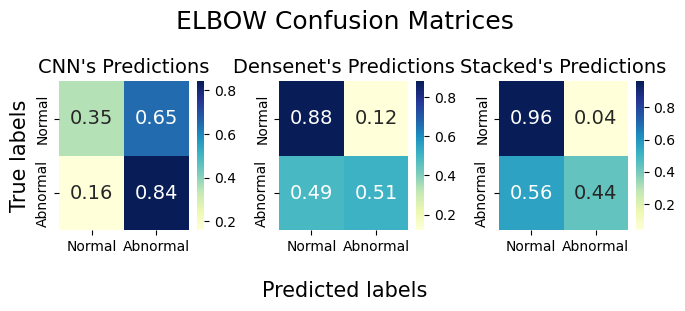

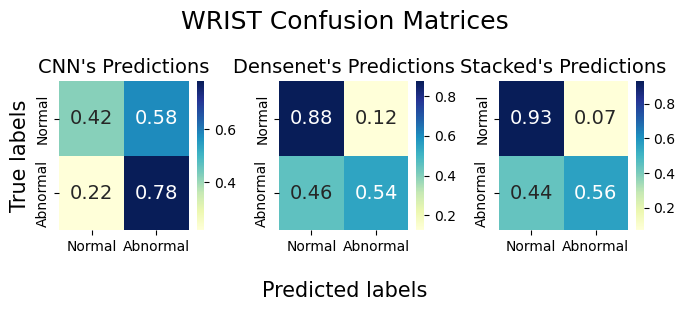

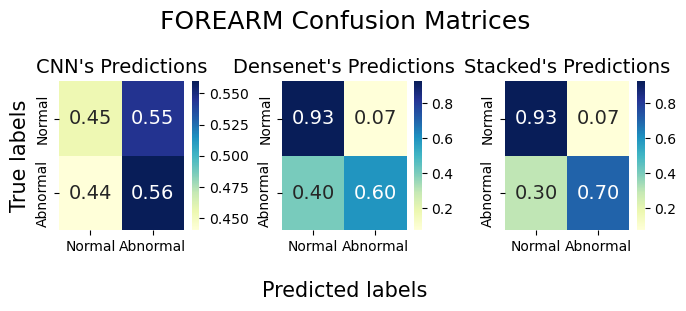

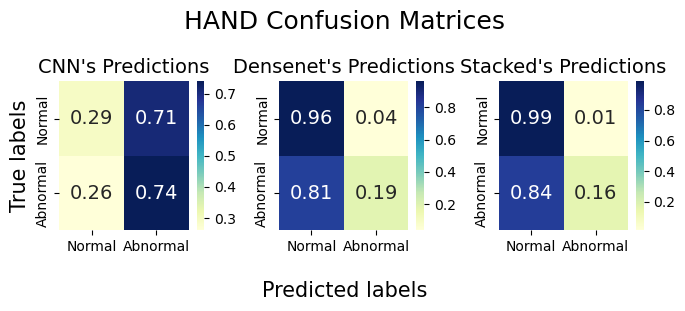

In [252]:
for bodypart in pd.unique(test.category):
    # fill dictionary with the cohen kappa score of each bodypart
    cnn_bodypart = tf.round(cnn_pred).numpy()[test.loc[test.category == bodypart].index].reshape(-1,)
    densenet_bodypart = tf.round(densenet_pred).numpy()[test.loc[test.category == bodypart].index].reshape(-1,)
    stacked_bodypart = tf.round(stacked_pred).numpy()[test.loc[test.category == bodypart].index].reshape(-1,)

    true_bodypart = test.loc[test.category == bodypart].label.to_numpy().astype(int)
    plot_cm(true_labels=true_bodypart, 
            predicted_labels=[tf.round(cnn_bodypart), 
                              tf.round(densenet_bodypart), 
                              tf.round(stacked_bodypart)], 
            models=["CNN", "Densenet", "Stacked"], 
            title=bodypart[3:],
            size=(7,3))

In [284]:
def kappa_bodypart_plot(test, cnn_label_preds, densenet_label_preds, stacked_label_preds):
    """
    Plots the cohen kappa scores for each body part
    """
    kappas = {}
    for bodypart in pd.unique(test.category):
        # fill dictionary with the cohen kappa score of each bodypart
        cnn_bodypart = cnn_label_preds.numpy()[test.loc[test.category == bodypart].index].reshape(-1,)
        densenet_bodypart = densenet_label_preds.numpy()[test.loc[test.category == bodypart].index].reshape(-1,)
        stacked_bodypart = stacked_label_preds.numpy()[test.loc[test.category == bodypart].index].reshape(-1,)

        true_bodypart = test.loc[test.category == bodypart].label.to_numpy().astype(int)
        kappas[bodypart[3:]] = [cohen_kappa_score(true_bodypart, cnn_bodypart),
                            cohen_kappa_score(true_bodypart, densenet_bodypart), 
                               cohen_kappa_score(true_bodypart, stacked_bodypart)]

    k = [key for key in kappas.keys()]
    v = [value for value in kappas.values()]

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    ax.bar(np.arange(len(k)) - 0.2, 
           [value[0] for value in v],
            width=0.2, color='#1f77b4', align='center', label='CNN',
            zorder=3)
    ax.bar(np.arange(len(k)),
            [value[1] for value in v],
            width=0.2, color='#ff7f0e', align='center', label='DenseNet',
            zorder=3)
    ax.bar(np.arange(len(k)) + 0.2,
            [value[2] for value in v],
            width=0.2, color='#2ca02c', align='center', label='Stacked',
            zorder=3)
    ax.set_xticklabels(k)
    ax.set_xticks(np.arange(len(k)))
    ax.grid(zorder=0)
    ax.legend()
    ax.set_title('Cohen Kappas for Each Bodypart', size=15);
    
    return plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


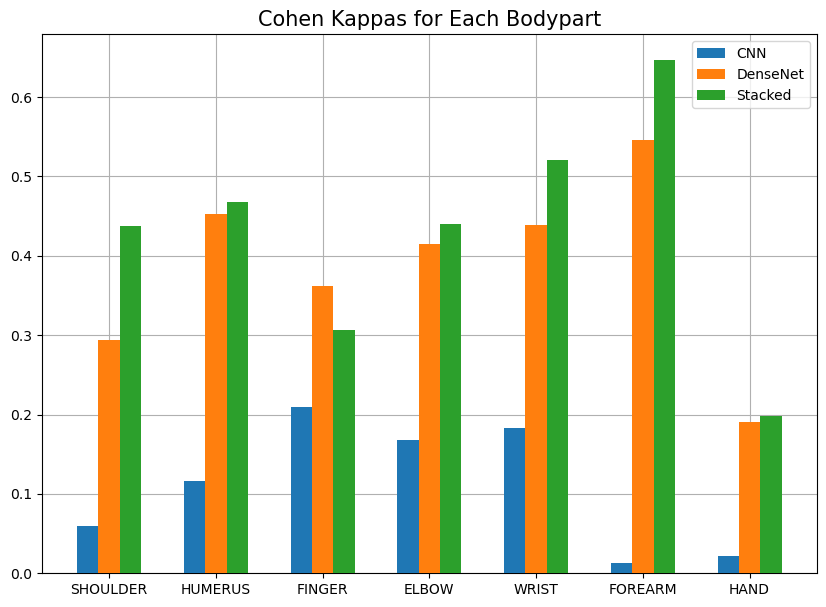

In [285]:
kappa_bodypart_plot(test, tf.round(cnn_pred), tf.round(densenet_pred), tf.round(stacked_pred))

In [283]:
def f1_score_plot(test, cnn_label_preds, densenet_label_preds, stacked_label_preds):
    """
    Plots the cohen kappa scores for each body part
    """
    kappas = {}
    for bodypart in pd.unique(test.category):
        # fill dictionary with the cohen kappa score of each bodypart
        cnn_bodypart = cnn_label_preds.numpy()[test.loc[test.category == bodypart].index].reshape(-1,)
        densenet_bodypart = densenet_label_preds.numpy()[test.loc[test.category == bodypart].index].reshape(-1,)
        stacked_bodypart = stacked_label_preds.numpy()[test.loc[test.category == bodypart].index].reshape(-1,)

        true_bodypart = test.loc[test.category == bodypart].label.to_numpy().astype(int)
        kappas[bodypart[3:]] = [f1_score(true_bodypart, tf.round(cnn_bodypart)),
                                f1_score(true_bodypart, tf.round(densenet_bodypart)), 
                                f1_score(true_bodypart, tf.round(stacked_bodypart))]

    k = [key for key in kappas.keys()]
    v = [value for value in kappas.values()]

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    ax.bar(np.arange(len(k)) - 0.2, 
           [value[0] for value in v],
            width=0.2, color='#1f77b4', align='center', label='CNN',
            zorder=3)
    ax.bar(np.arange(len(k)),
            [value[1] for value in v],
            width=0.2, color='#ff7f0e', align='center', label='DenseNet',
            zorder=3)
    ax.bar(np.arange(len(k)) + 0.2,
            [value[2] for value in v],
            width=0.2, color='#2ca02c', align='center', label='Stacked',
            zorder=3)
    ax.set_xticklabels(k)
    ax.set_xticks(np.arange(len(k)))
    ax.grid(zorder=0)
    ax.legend()
    ax.set_title('F1 Score for Each Bodypart', size=15);
    
    return plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


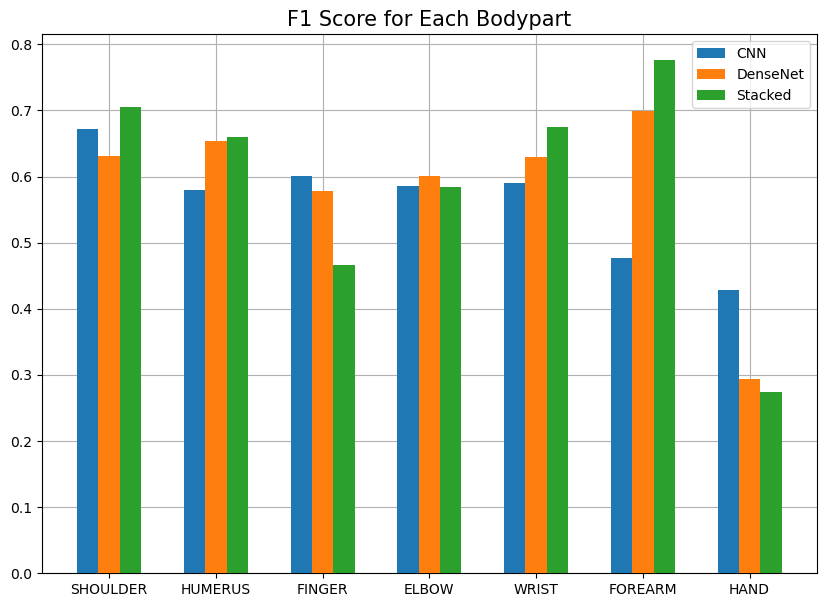

In [282]:
f1_score_plot(test, tf.round(cnn_pred), tf.round(densenet_pred), tf.round(stacked_pred))

# Optimizing prediction threshold

* Since the training data is imbalanced, we will try to find a threshold that will slightly favor the abnormal case, trying to increase the f1 score. If the impact on the accuracy is not that big we will keep this, thresolh. 

Validation data will be used for this optimization

## Validation predicitons

In [214]:
valid_iterator.reset
cnn_pred_valid = cnn.predict(valid_iterator)

valid_iterator.reset
densenet_pred_valid = pre_trained.predict(valid_iterator)

valid_iterator.reset
stacked_pred_valid = stacked.predict(valid_iterator)

31/31 [==============================] - 16s 517ms/step


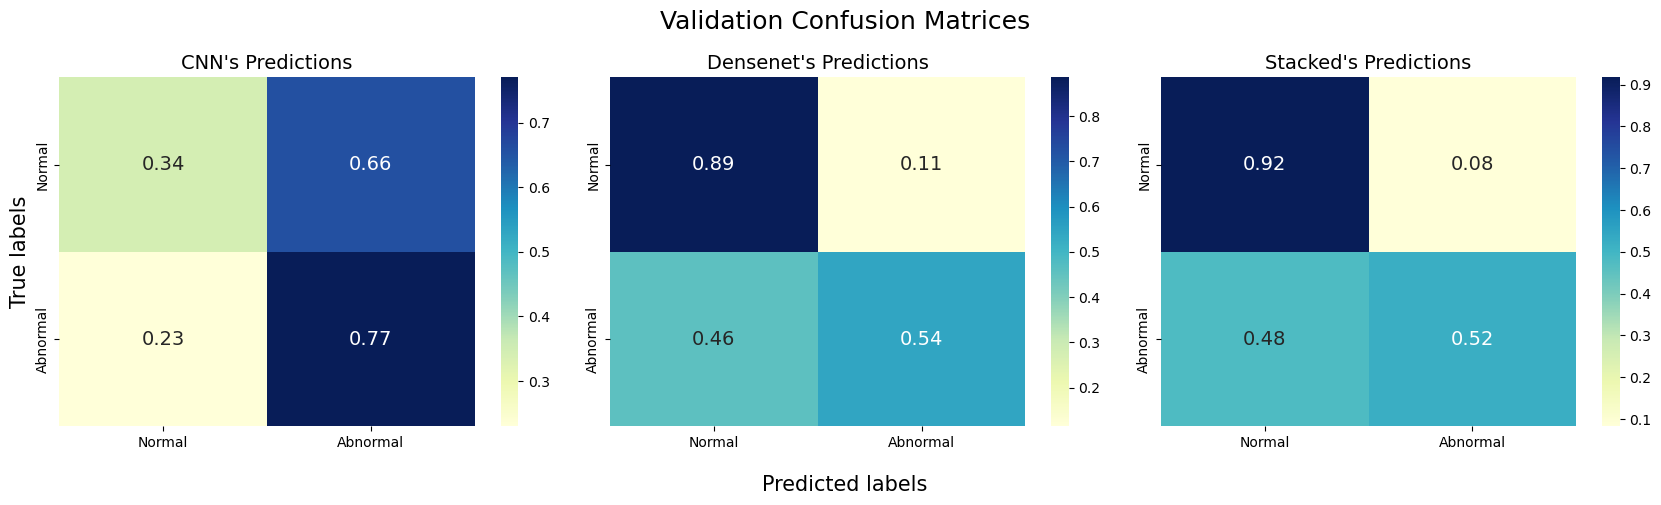

In [254]:
# Initial plots
true_labels_valid = valid.label.astype(int)
plot_cm(true_labels=true_labels_valid, predicted_labels=[tf.round(cnn_pred_valid), tf.round(densenet_pred_valid), tf.round(stacked_pred_valid)], models=["CNN", "Densenet", "Stacked"], title="Validation")

In [302]:
best_threshold: List[int] = []
for label, model in zip([cnn_pred_valid, densenet_pred_valid, stacked_pred_valid], ["CNN", "Densenet", "Stacked"]):

    print(f'Model: {model}')
    thresholds = np.arange(0, 0.5, 0.001)
    # evaluate each threshold
    f1_scores = [f1_score(true_labels_valid, tf.round(label+t)) for t in thresholds]
    roc_auc_scores = [roc_auc_score(true_labels_valid, label+t) for t in thresholds]# get best threshold
    accuracy = [accuracy_score(true_labels_valid, tf.round(label+t)) for t in thresholds]# get best threshold
    ix = np.argmax(f1_scores)
    best_threshold.append(thresholds[ix])
    print(f'Threshold:{thresholds[ix]:>11.3f}')
    print(f'F-Score:{ f1_scores[ix]:>13.5f}')
    print(f'Accuracy:{ accuracy[ix]:>12.5f}', end="\n\n")


Model: CNN
Threshold:      0.101
F-Score:      0.55994
Accuracy:     0.43536

Model: Densenet
Threshold:      0.178
F-Score:      0.66774
Accuracy:     0.68217

Model: Stacked
Threshold:      0.141
F-Score:      0.70260
Accuracy:     0.75473



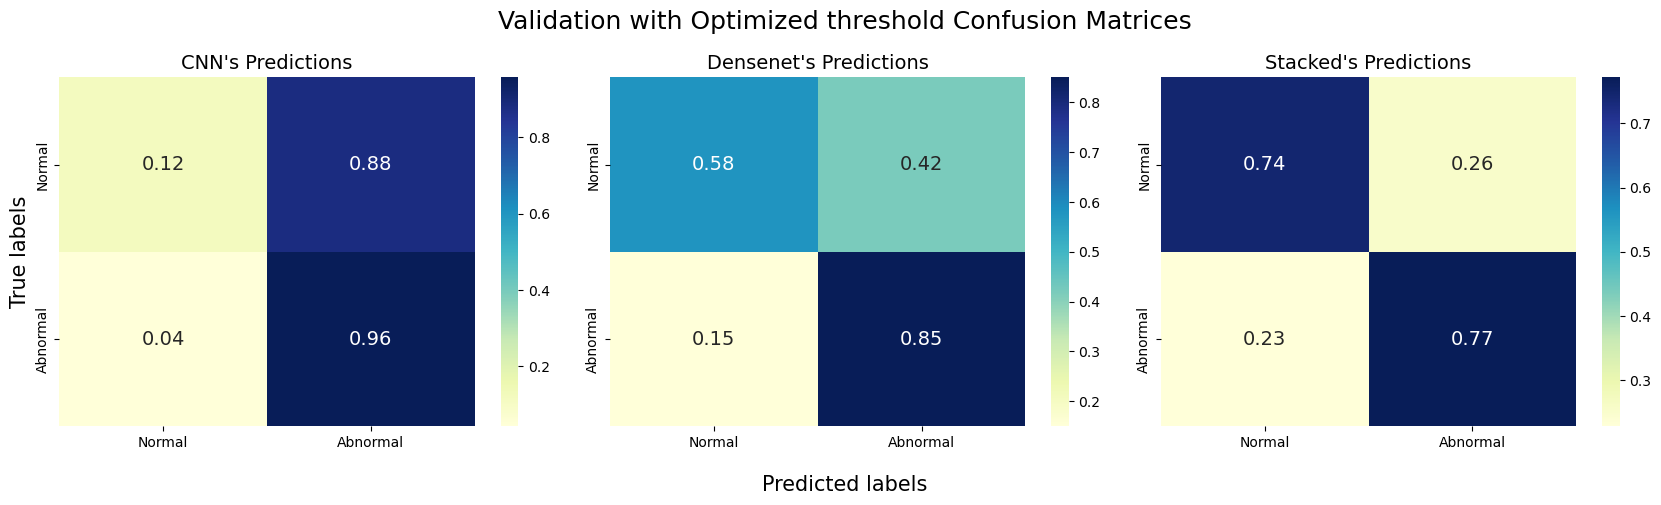

In [305]:
# optimized plots
true_labels_valid = valid.label.astype(int)
plot_cm(true_labels=true_labels_valid, 
        predicted_labels=[tf.round(cnn_pred_valid+best_threshold[0]), 
                          tf.round(densenet_pred_valid+best_threshold[1]), 
                          tf.round(stacked_pred_valid+best_threshold[2])], 
        models=["CNN", "Densenet", "Stacked"], title="Validation with Optimized threshold")

## Make predictions with new threshold on Test set

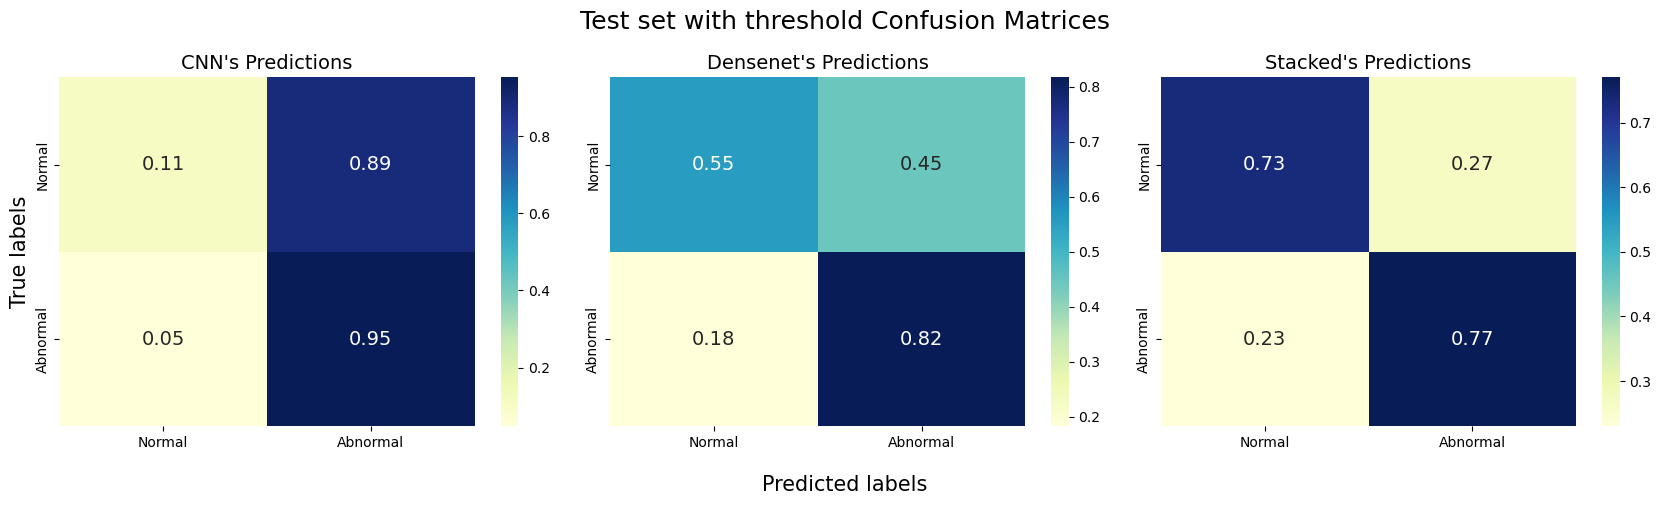

In [303]:
plot_cm(true_labels=true_labels, 
        predicted_labels=[tf.round(cnn_pred+best_threshold[0]), 
                          tf.round(densenet_pred+best_threshold[1]), 
                          tf.round(stacked_pred+best_threshold[2])], 
        models=["CNN", "Densenet", "Stacked"], 
       title="Test set with threshold")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


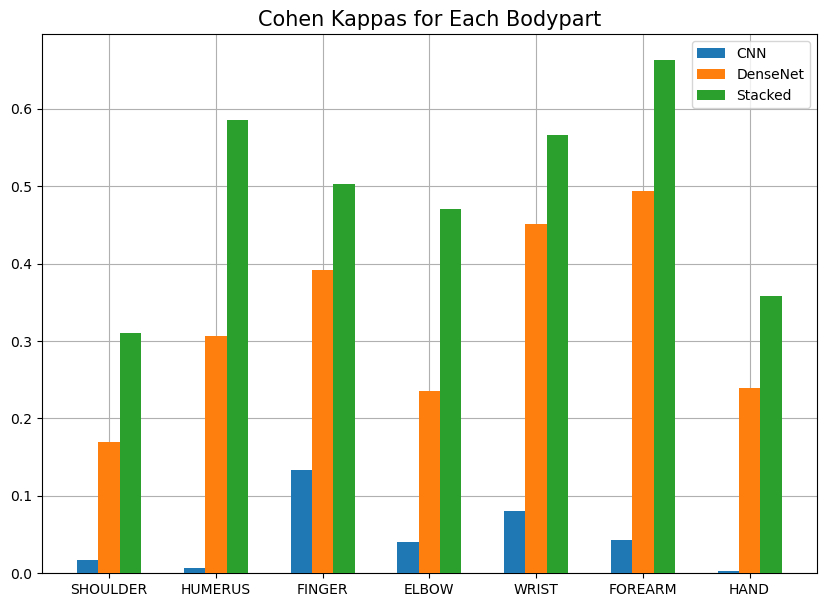

In [306]:
kappa_bodypart_plot(test, tf.round(cnn_pred+best_threshold[0]), tf.round(densenet_pred+best_threshold[1]), tf.round(stacked_pred+best_threshold[2]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


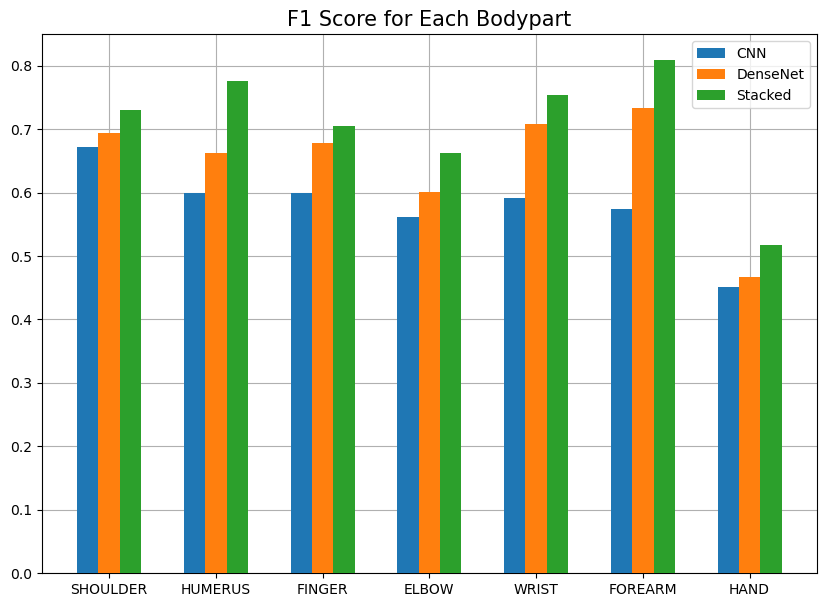

In [307]:
f1_score_plot(test, tf.round(cnn_pred+best_threshold[0]), tf.round(densenet_pred+best_threshold[1]), tf.round(stacked_pred+best_threshold[2]))

## Predict based on body part/patient

* Since we have more than one picture per patient/bodypart, we can use that to our advantage to make the predictions.

In [376]:
test_copy = test[["category", "patient_id", "label"]].copy()
test_copy.loc[:, ("pred")] = stacked_pred+best_threshold[2]
test_copy["label"] = test_copy["label"].astype(int)
grouped_results = test_copy.groupby(by=["patient_id", "category"], group_keys=False).mean()
true_pred_grouped = grouped_results["label"].to_numpy(dtype=int)
pred_grouped = tf.round(grouped_results["pred"]).numpy()
grouped_results.head()

label      pred
patient_id   category                    
patient00001 XR_SHOULDER    1.0  0.583815
patient00004 XR_SHOULDER    1.0  0.461198
patient00031 XR_ELBOW       0.0  0.555932
             XR_SHOULDER    1.0  0.758539
patient00034 XR_ELBOW       1.0  0.667481

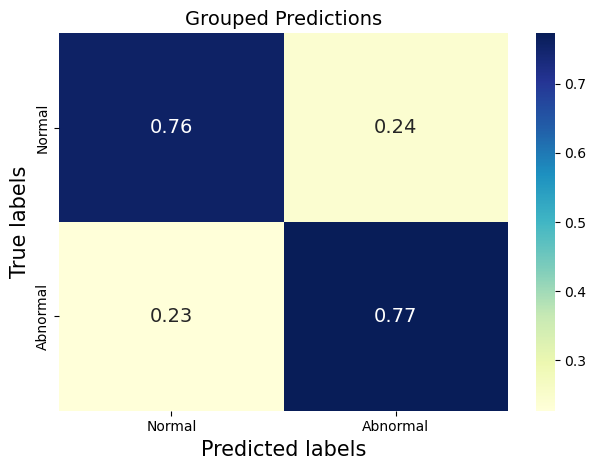

In [377]:
# Plot the confusion matrix for the grouped predictions
cm = confusion_matrix(true_pred_grouped, pred_grouped)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fmt = '.2f'

sns.heatmap(cm, annot=True, fmt=fmt,cmap=plt.cm.YlGnBu,  annot_kws={"size":14}, 
            yticklabels=['Normal', 'Abnormal'], 
            xticklabels=['Normal', 'Abnormal']) 
        
plt.ylabel('True labels', fontsize=15)
plt.title(f'Grouped Predictions', size=14)
plt.xlabel(f'Predicted labels', fontsize=15)
plt.tight_layout()
plt.show()

In [378]:
print(classification_report(true_pred_grouped, pred_grouped))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       877
           1       0.66      0.77      0.71       528

    accuracy                           0.76      1405
   macro avg       0.75      0.76      0.75      1405
weighted avg       0.78      0.76      0.77      1405



# Clean-up Models

In [34]:
for _model in [cnn, pre_trained, stacked]:
    clean_up(_model)